In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (79).jpg
/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (74).jpg
/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (11).jpg
/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (78).jpg
/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (8).jpg
/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (12).jpg
/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (72).jpg
/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (76).jpg
/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (77).jpg
/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (6).jpg
/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (13).jpg
/kaggle/input/dataset-25/Dataset_25/Valid/daging rendang/daging_rendang (9).jpg
/kaggle/input/dataset-25/Datase

In [2]:
#Import library
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Ditemukan GPU di: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("Tidak ada GPU , menggunakan {}.".format(device_name))

Ditemukan GPU di: /device:GPU:0


In [4]:
train_dir = "/kaggle/input/dataset-25/Dataset_25/Train"
val_dir = "/kaggle/input/dataset-25/Dataset_25/Valid"
test_dir = "/kaggle/input/dataset-25/Dataset_25/Test"

**PREPROCESSING**

In [5]:
#Data Augmentation
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip = True,
    rotation_range = 0.2,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255.
)

In [6]:
#Declare size & Batch
train_batch_size = 30
val_batch_size = 30
test_batch_size = 30
img_height = 150
img_width = 150

In [7]:
train_ds = train_generator.flow_from_directory(
    directory = train_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = train_batch_size,
    shuffle = True,
    seed = 42,
)

val_ds = val_generator.flow_from_directory(
    directory = val_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = val_batch_size,
    shuffle = True,
    seed = 42,
)

test_ds = test_generator.flow_from_directory(
    directory = test_dir,
    target_size = (img_height, img_width),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = test_batch_size,
    shuffle = False
)

Found 2188 images belonging to 25 classes.
Found 500 images belonging to 25 classes.
Found 198 images belonging to 25 classes.


In [8]:
#Display class
class_names = train_ds.class_indices
print(class_names)

{'ayam goreng': 0, 'bakwan': 1, 'burger': 2, 'capcay': 3, 'daging rendang': 4, 'dendeng batokok': 5, 'donat': 6, 'es krim': 7, 'gudeg': 8, 'gulai ikan': 9, 'gulai tambusu': 10, 'kebab': 11, 'kerak telor': 12, 'mie aceh': 13, 'nasi goreng': 14, 'nasi pecel': 15, 'papeda': 16, 'pempek': 17, 'rawon': 18, 'sate': 19, 'serabi': 20, 'soto lamongan': 21, 'tahu sumedang': 22, 'telur balado': 23, 'tempe goreng': 24}


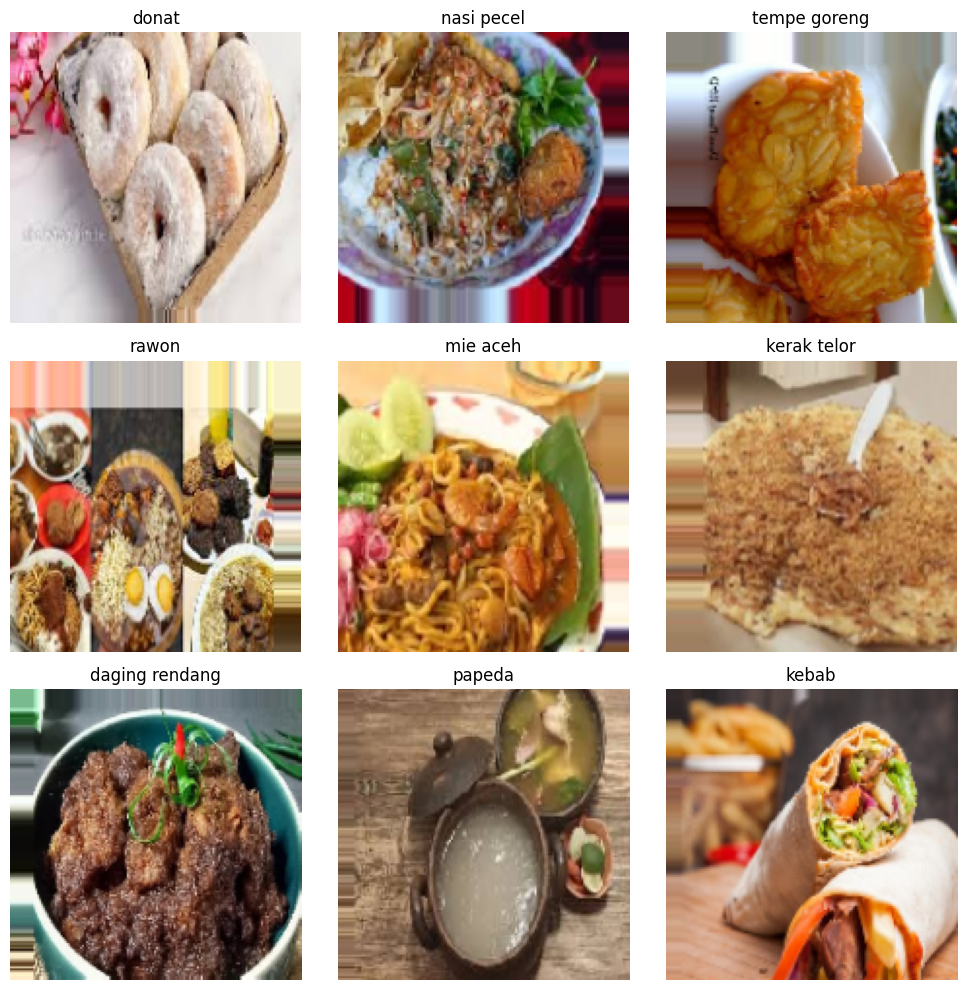

In [9]:
# Fetch the first batch of images and labels from train_ds
images, labels = next(train_ds)

# Display the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    # Retrieve the label index from the one-hot encoded format
    label_index = np.argmax(labels[i])

    # Get the class name corresponding to the label index
    for class_name, index in train_ds.class_indices.items():
        if index == label_index:
            plt.title(class_name)
            break

    plt.axis("off")

plt.tight_layout()
plt.show()

**MAKE THE MODELS**

In [10]:
pre_trained_model = tf.keras.applications.MobileNetV2(
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax'
)

14536120/14536120 [==============================] - 0s 0us/step


In [11]:
# Adding more layer in top of based model for fine tuning
inputs = pre_trained_model.input

x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Increase dropout

outputs = tf.keras.layers.Dense(25, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [12]:
# Set callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('val_accuracy') is not None:
            if logs.get('accuracy') > 0.87 and logs.get('val_accuracy') > 0.87:
                print("\nReached 87% accuracy in training and validation. Stopping training.")
                self.model.stop_training = True
                print(logs)

callbacks = myCallback()

In [13]:
# Set training parameters
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['acc'])

In [14]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 98% accuracy
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs = 250,
                    callbacks = [callbacks])

Epoch 1/250
73/73 [==============================] - 81s 516ms/step - loss: 3.0799 - acc: 0.1508 - val_loss: 3.4255 - val_acc: 0.0640
Epoch 2/250
73/73 [==============================] - 22s 299ms/step - loss: 2.8992 - acc: 0.1741 - val_loss: 3.2715 - val_acc: 0.0400
Epoch 3/250
73/73 [==============================] - 22s 303ms/step - loss: 2.8724 - acc: 0.1321 - val_loss: 3.2614 - val_acc: 0.0480
Epoch 4/250
73/73 [==============================] - 22s 304ms/step - loss: 2.8913 - acc: 0.1229 - val_loss: 3.4447 - val_acc: 0.0640
Epoch 5/250
73/73 [==============================] - 22s 301ms/step - loss: 2.6883 - acc: 0.1801 - val_loss: 3.8193 - val_acc: 0.0540
Epoch 6/250
73/73 [==============================] - 22s 301ms/step - loss: 2.5982 - acc: 0.1947 - val_loss: 4.2340 - val_acc: 0.0420
Epoch 7/250
73/73 [==============================] - 22s 298ms/step - loss: 2.6093 - acc: 0.1883 - val_loss: 3.8955 - val_acc: 0.0380
Epoch 8/250
73/73 [==============================] - 21s 290ms

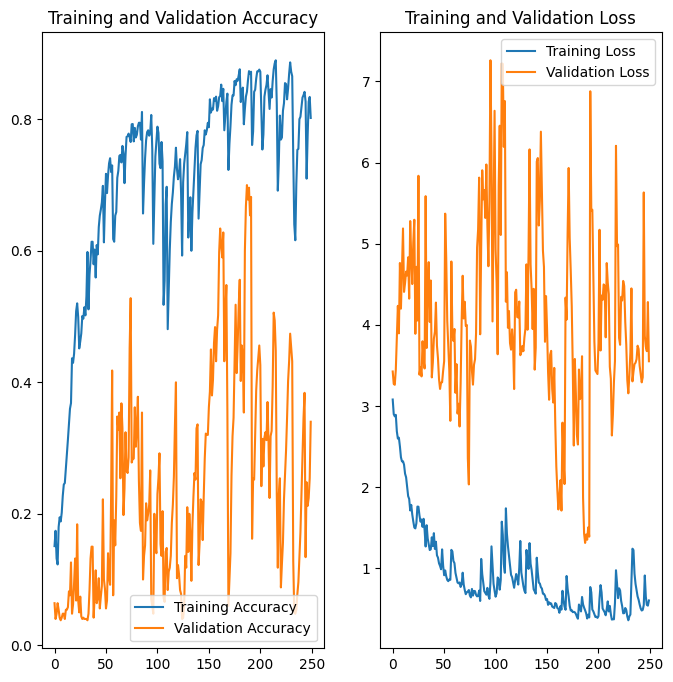

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

7/7 [==============================] - 4s 397ms/step


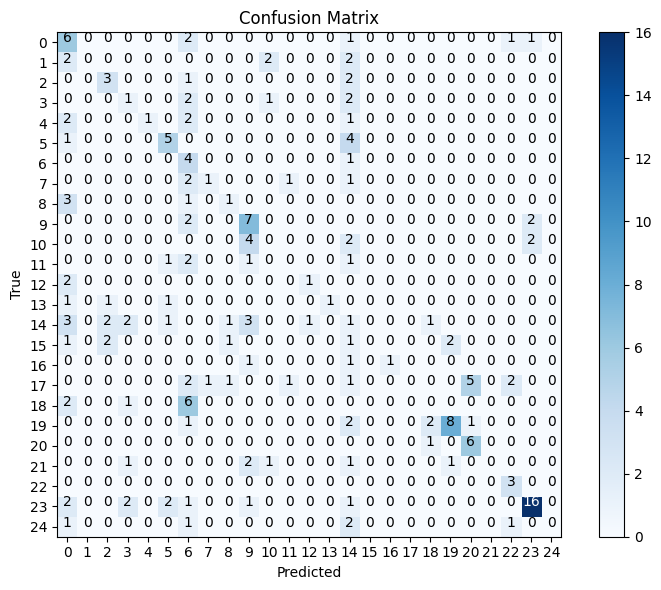


F1 Score: 0.30410347440050856


In [16]:
# Mendapatkan prediksi dari model pada data uji
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

# Mendapatkan label sebenarnya dari data uji
y_true = test_ds.classes

# Membuat confusion matrix
confusion = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix menggunakan matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

num_classes = len(np.unique(y_true))
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))

plt.xlabel('Predicted')
plt.ylabel('True')

# Menambahkan angka di dalam kotak confusion matrix
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, confusion[i, j],
                 horizontalalignment='center',
                 color='white' if confusion[i, j] > (confusion.max() / 2) else 'black')

plt.tight_layout()
plt.show()

# Menghitung F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("\nF1 Score:", f1)

7/7 [==============================] - 1s 137ms/step


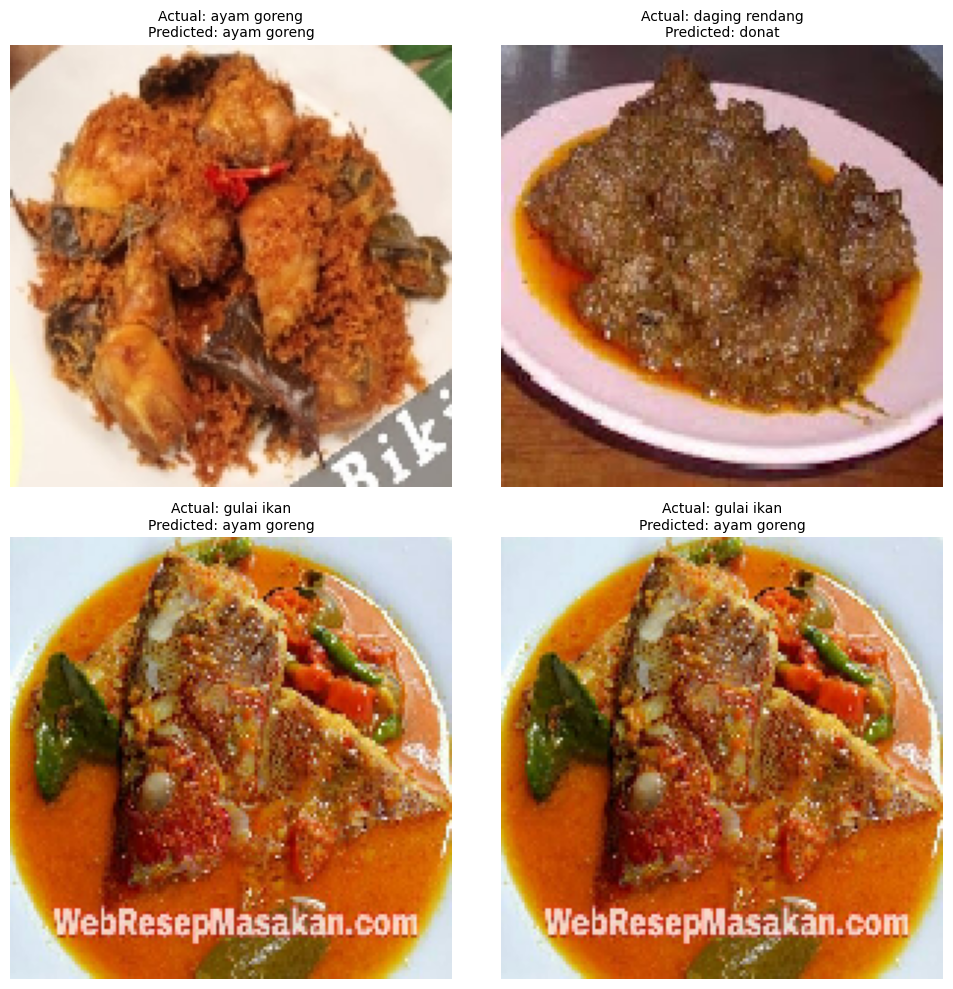

In [17]:
# Mendapatkan prediksi dari model pada data uji
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

# Mendapatkan gambar acak dan label dari data uji
num_rows, num_cols = 2, 2
plt.figure(figsize=(10, 10))

for i in range(num_rows * num_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    # Ambil gambar acak dari test_ds
    rand_index = np.random.randint(len(test_ds))
    image, label = test_ds[rand_index]

    # Tampilkan gambar
    plt.imshow(image[0])
    plt.axis('off')

    # Label actual dan predicted
    true_label = np.argmax(label)  # Ambil label dari tensor dengan argmax
    pred_label = y_pred[rand_index]

    # Konversi label menjadi nama kelas
    true_class = list(test_ds.class_indices.keys())[true_label]
    pred_class = list(test_ds.class_indices.keys())[pred_label]

    # Tambahkan label di atas gambar
    plt.title(f'Actual: {true_class}\nPredicted: {pred_class}', fontsize=10)

plt.tight_layout()
plt.show()

In [18]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('/kaggle/working/model.tflite', 'wb') as f:
    f.write(tflite_model)

model.save('/kaggle/working/balanzio_mobilenetv2_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
